# PRIM analytics notebook

Perform the complete scenario discovery analysis over a dataset

## Imports and auxilliary functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

import seaborn as sns
from utils.colors import DTU_COLOR_HEX, DTU_BIN, DTU_BIN_HC
colors = list(DTU_COLOR_HEX.values())
sns.set_palette(sns.color_palette(colors))
CM_DTU_BIN = LinearSegmentedColormap.from_list('dtu_bin', DTU_BIN, N=2)

from models.prim import PrimClassifier, coverage, density
from models.sampler import Sampler
from utils.data_loader import load_metadata, load_betas

%matplotlib inline

In [2]:
def get_distance(limits, base):
    """ Compute the distance between a box (defined by limits) and a benchmark
    """
    df = base.join(limits, lsuffix='_base', how='outer')
    df = df.fillna(0)
    df['distance'] = (df['min'] - df['min_base'])**2 + (df['max'] - df['max_base'])**2
    return np.sqrt(df['distance'].sum())

In [3]:
def compute_exploration_metric(limits, cube):
    """ For each restricted dimensions, evaluate the ratio between the number of points in the prim box 
    and the number of points if a random sampling was used
    """
    limits_copy = limits.copy()
    limits_copy['width'] = limits_copy['max'] - limits_copy['min']
    bounds['width'] = bounds['max'] - bounds['min']
    bounds.index = bounds['name'].values
    limits_copy = limits_copy.join(bounds['width'], rsuffix='_bounds')
    limits_copy['box_density'] = limits_copy['width'] / limits_copy['width_bounds']
    d, d_gap = np.empty(len(limits_copy)), np.empty(len(limits_copy))
    for k, name in enumerate(limits_copy.index):
        d[k] = cube[cube[name].between(limits_copy['min'][name], limits_copy['max'][name])].shape[0] / cube.shape[0]
        d_gap[k] = (d[k]/limits_copy['box_density'][name] -  1) * 100
        print(f"Density of points in the box for feature {name}: {d[k]}, with a gap {round(d_gap[k],2)}%")
    print("Exploration metric = ", d_gap.mean())

In [4]:
## Metaparameters, populations

ACTIVITY = 'LeisureT'
THRESHOLD = 7900

betas_dp = load_betas('dp')
names = list(betas_dp.keys())[:-1]

df, betas, bounds = load_metadata()

params = pd.read_csv('data/params.csv')

## Base data and datasets, first analysis

In [5]:
## Benchmark dataset and results

data_lhs = pd.read_csv(f'data/out/LHS/1685970373.084523.csv')
# data = pd.read_csv('qd_results_32.csv')
data_lhs = data_lhs.drop(['Unnamed: 0'], axis=1)
# data_standardized = (data - data.mean()) / data.std()
cube_lhs = data_lhs[names]
counts_lhs = data_lhs[ACTIVITY]

pc = PrimClassifier(
        activity = ACTIVITY,
        threshold = THRESHOLD,
        peel_alpha=0.1
    )
box_lhs = pc.fit(cube_lhs, counts_lhs)
limits_lhs = box_lhs.limits

In [6]:
## Concentration is 0 as it's a random sampling

compute_exploration_metric(limits_lhs, cube_lhs)

Density of points in the box for feature age65_travel: 0.5342, with a gap 0.04%
Density of points in the box for feature retired_travel: 0.659, with a gap 0.01%
Density of points in the box for feature LIC_travel: 0.9032, with a gap 0.01%
Density of points in the box for feature fam_income_travel: 0.9046, with a gap 0.01%
Exploration metric =  0.019043414703828754


In [7]:
## Dataset to study

filename = 'BO/ax_ei_100'

data = pd.read_csv(f'data/out/{filename}.csv')
data = data.drop(['Unnamed: 0'], axis=1)
# data_standardized = (data - data.mean()) / data.std()
cube = data[names]
counts = data[ACTIVITY]

print(f"Dataset shape: {cube.shape}")
print("Sampling density J = ", np.power(len(cube), 1/len(names)))

Dataset shape: (1201, 18)
Sampling density J =  1.4828107388702576


[]

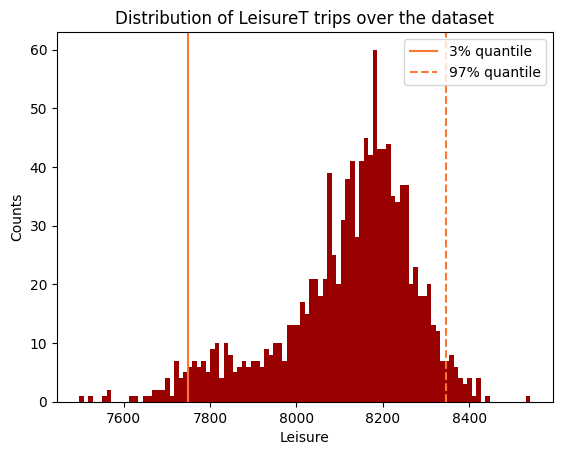

In [8]:
counts.hist(bins=100, grid=False)
plt.axvline(counts.quantile(0.03), c=DTU_COLOR_HEX['orange'], label='3% quantile')
plt.axvline(counts.quantile(0.97), c=DTU_COLOR_HEX['orange'], linestyle='dashed', label='97% quantile')
plt.xlabel('Leisure')
plt.ylabel('Counts')
plt.legend()
plt.title(f"Distribution of {ACTIVITY} trips over the dataset")
plt.plot()

In [9]:
plt.plot(counts.expanding().mean())
plt.xlabel('Number of extra points sampled')
plt.ylabel('Average count of leisure trips')

Text(0, 0.5, 'Average count of leisure trips')

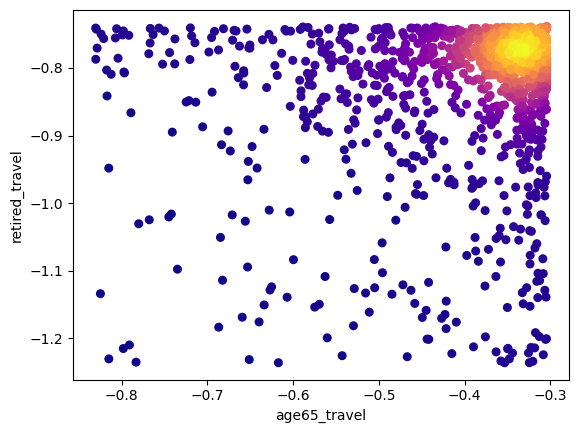

In [10]:
## Heatmap of the sampling density
from scipy.stats import gaussian_kde
CM_DTU_GRAD = LinearSegmentedColormap.from_list('dtu_bin', DTU_BIN_HC, N=len(cube))

x = cube['age65_travel']
y = cube['retired_travel']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# z = gaussian_kde(cube.transpose())(cube.transpose())

fig, ax = plt.subplots()

ax.scatter(x, y, c=z, s=30, cmap='plasma')
plt.xlabel('age65_travel')
plt.ylabel('retired_travel')
plt.show()

## PRIM

In [11]:
pc = PrimClassifier(
        activity = ACTIVITY,
        threshold = THRESHOLD,
        peel_alpha=0.1
    )
box = pc.fit(cube, counts)
limits = box.limits
y_bin = pc._compute_bin(counts)
y_pred = pc.predict(cube)

## Display the output prim box
print(box)

Box 1 [Peeling Trajectory 2]
    Stats
        Coverage: 0.877934
        Density:  0.961934
        Mass:     0.809326
        Res Dim:  2.000000
        Mean:     0.961934
    Limits
                             min      max  qp values
        retired_travel -1.003422 -0.73908   0.000008
        age65_travel   -0.563836 -0.30444   0.000123


In [12]:
compute_exploration_metric(limits, cube)

Density of points in the box for feature retired_travel: 0.8992506244796004, with a gap 69.36%
Density of points in the box for feature age65_travel: 0.8859283930058285, with a gap 82.08%
Exploration metric =  75.71829407755476


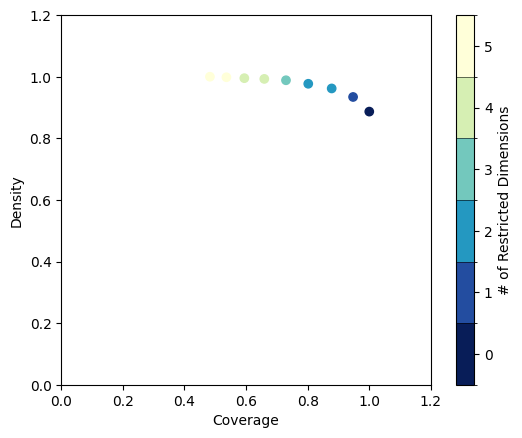

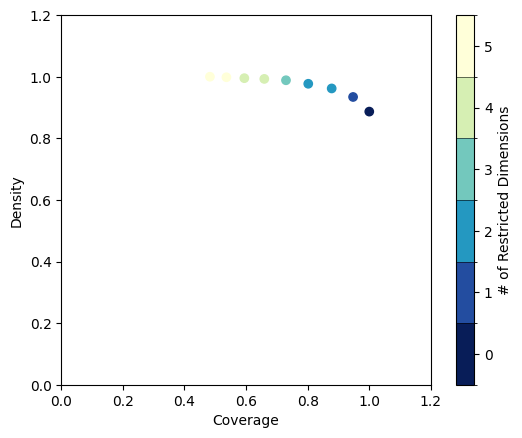

In [13]:
box.show_tradeoff()

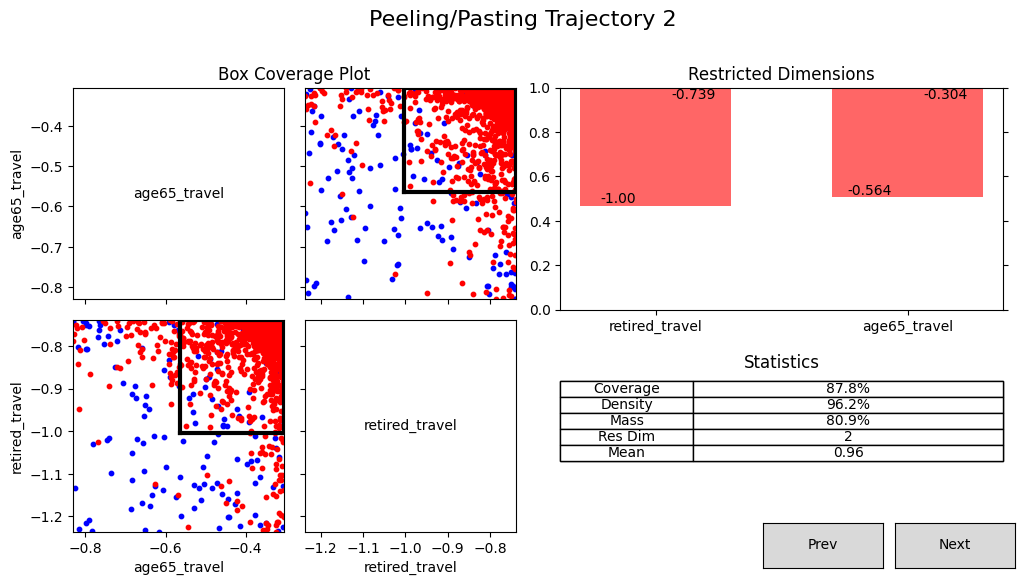

In [14]:
box.show_details()

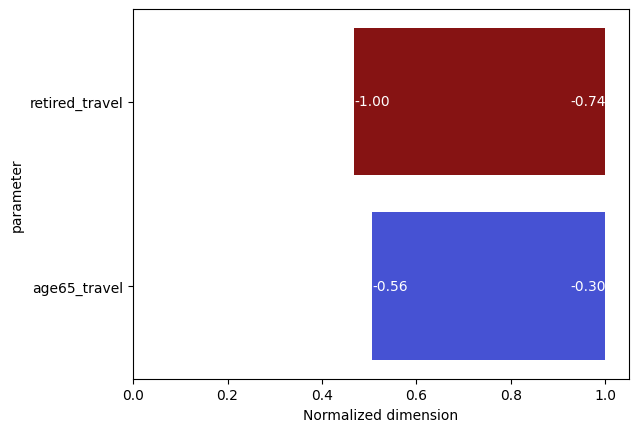

In [15]:
pc.plot_scenario_identification(cube, limits['min'].values, limits['max'].values, colors)

In [16]:
## Partial coverage and density while increasing the number of restricted dimensions

limits = box.limits
cov, den = np.empty(len(limits)), np.empty(len(limits))
for k in range(1,len(limits)+1):
    y_pred = pc.predict(cube, limits.iloc[:k])
    cov[k-1], den[k-1] = coverage(y_bin,y_pred), density(y_bin, y_pred)
print("coverage: ", cov)
print("density: ", den)

coverage:  [0.94741784 0.87793427]
density:  [0.93425926 0.96193416]


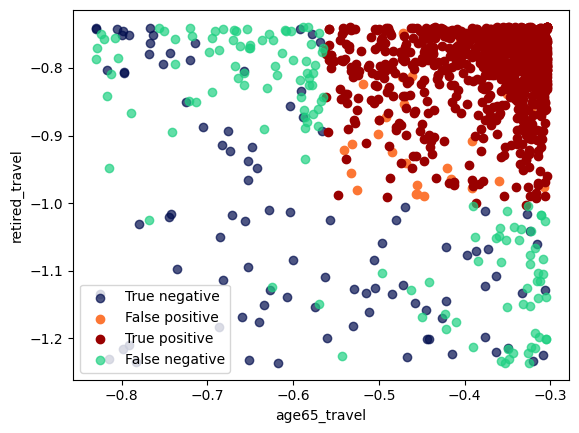

In [17]:
# feature1, feature2 = 10, 0
feature1, feature2 = 7, 14
mask_true_positive = np.array((y_bin == 1) & (y_pred == 1))
mask_true_negative = np.array((y_bin == 0) & (y_pred == 0))
mask_false_positive = np.array((y_bin == 0) & (y_pred == 1))
mask_false_negative = np.array((y_bin == 1) & (y_pred == 0))
plt.scatter(cube.iloc[mask_true_negative,feature1], cube.iloc[mask_true_negative,feature2], c=DTU_COLOR_HEX['navy_blue'], alpha=0.7, label="True negative")
plt.scatter(cube.iloc[mask_false_positive,feature1], cube.iloc[mask_false_positive,feature2], c=DTU_COLOR_HEX['orange'], label="False positive")
plt.scatter(cube.iloc[mask_true_positive,feature1], cube.iloc[mask_true_positive,feature2], c=DTU_COLOR_HEX['red'], label="True positive")
plt.scatter(cube.iloc[mask_false_negative,feature1], cube.iloc[mask_false_negative,feature2], c=DTU_COLOR_HEX['green'], alpha=.7,  label="False negative")
plt.xlabel(f"{cube.columns[feature1]}")
plt.ylabel(f"{cube.columns[feature2]}")
plt.legend()
plt.show()

In [18]:

def draw_rect(cube, counts, f1, f2, idx, label=None):
    pc = PrimClassifier(
        activity = ACTIVITY,
        threshold = THRESHOLD,
        peel_alpha=0.1
    )
    box = pc.fit(cube, counts)
    # mask_box = np.array(y_pred == 1)
    limits = box.limits.transpose()
    if isinstance(label, type(None)):
        label = f'{len(cube)}'
    try:
        width, heigth = limits[f1].iloc[1] - limits[f1].iloc[0], limits[f2].iloc[1] - limits[f2].iloc[0]
        rect=mpatches.Rectangle((limits[f1].iloc[0], limits[f2].iloc[0]),width, heigth, 
                                fill = False,
                                color = list(DTU_COLOR_HEX.keys())[idx],
                                linewidth = 2,
                                label = label)
        plt.gca().add_patch(rect)
        return box
    except:
        print(f"Box is missing one of the index {f1} or {f2}.")
    


In [19]:
resampling = np.empty((100,18))
sample_size = int(len(cube)/2)

for i in range(100):
    sample = cube.sample(sample_size).index
    box = pc.fit(cube.iloc[sample], counts.iloc[sample])
    resampling[i] = [1 if c in box.limits.index else 0 for c in cube.columns]
resampling = pd.DataFrame(resampling, columns=cube.columns)

resampling.mean().sort_values(ascending=False).head()

retired_travel       1.00
age65_travel         0.88
LIC_travel           0.30
ageUpto19_travel     0.21
fam_income_travel    0.01
dtype: float64

In [20]:
box.peeling_trajectory

coverage   density      mean res dim      mass  harmonic mean
0  1.000000  0.890000  0.890000       0  1.000000       0.000000
1  0.951311  0.940741  0.940741       1  0.900000       0.963338
2  0.883895  0.971193  0.971193       2  0.810000       1.127389
3  0.805243  0.983982  0.983982       2  0.728333       1.087690
4  0.732210  0.994911  0.994911       3  0.655000       1.109395
5  0.661049  1.000000  1.000000       4  0.588333       1.085875